# Cenaero

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)

In [60]:
# Constants

NUM_SEQUENCES = 121
DATA_PATH = '../data/38Q31TzlO-{}/npz_data/data.npz'
PARAMS_PATH = '../data/38Q31TzlO-{}/Minamo_Parameters-Wall2D.txt'
SEED = 20210831

In [61]:
def load_data(simulation_ids, recurrent=False):
    
    inputs, targets = [], []
    
    for simulation_id in simulation_ids:

        data = np.load(DATA_PATH.format(simulation_id))

        # Unused
        # T_top = data['T_top']
        # x = data['x']
        # y = data['y']
        # temperatures = data['temperatures']
        
        # Parse parameters
        with open(PARAMS_PATH.format(simulation_id)) as params_file:
            lines = params_file.read().splitlines()
            power = float(lines[0].split(' = ')[1])
            break_time = float(lines[1].split(' = ')[1])
        
        if recurrent:
            time = data['time']
            delta = time.copy()
            delta[1:] = time[1:] - time[:-1]
            laser_position = data['laser_position_x']
            laser_power = data['laser_power']
            input = np.stack([delta, laser_position, laser_power], axis=1)
        else:
            time = data['time']
            laser_position = data['laser_position_x']
            laser_power = data['laser_power']
            power = np.full(laser_power.shape, power)
            break_time = np.full(laser_power.shape, break_time)
            input = np.stack([time, laser_position, laser_power, power, break_time], axis=1)

        # Target data
        target = np.stack([data['T{}'.format(i + 1)] for i in range(6)], axis=1)

        inputs.append(input)
        targets.append(target)
    
    if not recurrent:
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        return inputs, targets
        
    else:
        max_len = max(input.shape[0] for input in inputs)
        input_seq_lens, target_seq_lens = [], []
        
        for i, input in enumerate(inputs):
            inputs[i] = np.pad(input, [(0, max_len - input.shape[0]), (0, 0)])
            input_seq_lens.append(input.shape[0])
        for i, target in enumerate(targets):
            targets[i] = np.pad(target, [(0, max_len - target.shape[0]), (0, 0)])
            target_seq_lens.append(target.shape[0])
        
        inputs = np.stack(inputs, axis=1)
        targets = np.stack(targets, axis=1)
        
        return inputs, targets, input_seq_lens, target_seq_lens

In [62]:
# Preview of the data

inputs, targets = load_data(range(1, 8 + 1), recurrent=False)

print('inputs:', inputs.shape)
print('targets:', targets.shape)

inputs: (11072, 5)
targets: (11072, 6)


## Train, test and validation split

In [63]:
np.random.seed(SEED)
permutation = np.random.permutation(np.arange(1, NUM_SEQUENCES + 1))
first_split = int(0.7 * NUM_SEQUENCES)
second_split = int(0.85 * NUM_SEQUENCES)
train_sequence_ids = permutation[:first_split]
eval_sequence_ids = permutation[first_split:second_split]
test_sequence_ids = permutation[second_split:]

In [64]:
train_inputs, train_targets = load_data(train_sequence_ids, recurrent=False)
eval_inputs, eval_targets = load_data(eval_sequence_ids, recurrent=False)
test_inputs, test_targets = load_data(test_sequence_ids, recurrent=False)

18148.226945066574


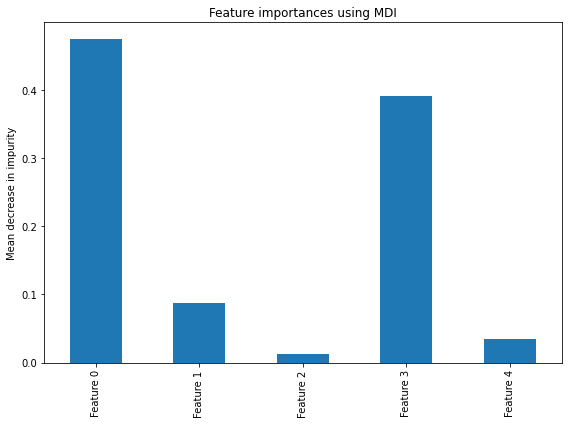

In [66]:
# Decision Tree training
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=None, random_state=SEED)
dt.fit(train_inputs, train_targets)

# Decision Tree evaluation
test_preds = dt.predict(test_inputs)
MSE = ((test_preds - test_targets) ** 2).sum() / test_targets.shape[0]
print(MSE)

# Get feature importance
feature_names = [f'Feature {i}' for i in range(train_inputs.shape[1])]

importances = dt.feature_importances_

dt_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
dt_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

12796.072311303085


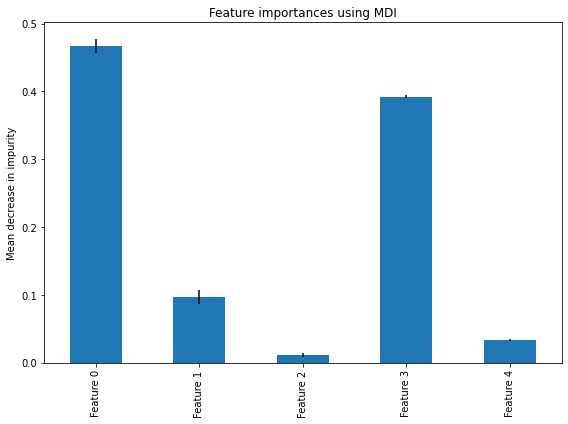

In [67]:
# Random Forest training
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=None, n_jobs=-1, random_state=SEED)
rf.fit(train_inputs, train_targets)

# Random Forest evaluation
test_preds = rf.predict(test_inputs)
MSE = ((test_preds - test_targets) ** 2).sum() / test_targets.shape[0]
print(MSE)

# Get feature importance
feature_names = [f'Feature {i}' for i in range(train_inputs.shape[1])]

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

6143.457848437732


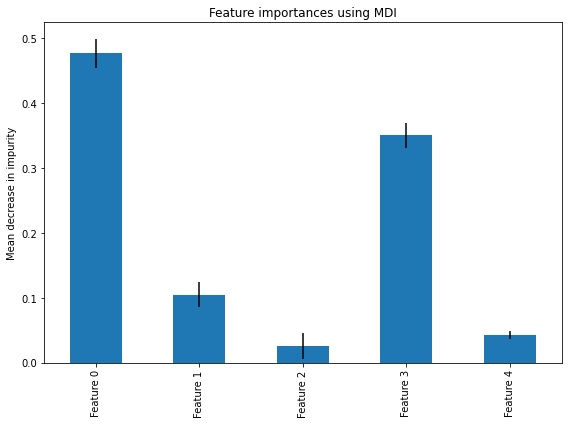

In [54]:
# Extra Trees training
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor

xt = ExtraTreesRegressor(n_estimators=200, max_depth=None, n_jobs=-1, random_state=SEED)
xt.fit(train_inputs, train_targets)

# Extra Trees evaluation
test_preds = xt.predict(test_inputs)
MSE = ((test_preds - test_targets) ** 2).sum() / test_targets.shape[0]
print(MSE)

# Get feature importance
feature_names = [f'Feature {i}' for i in range(train_inputs.shape[1])]

importances = xt.feature_importances_
std = np.std([tree.feature_importances_ for tree in xt.estimators_], axis=0)

xt_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
xt_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Plot results

In [10]:
# Choose random evaluation sequence
sample_test_id = np.random.choice(test_sequence_ids, size=(1,))
sample_test_inputs, sample_test_targets = load_data(sample_test_id, recurrent=False)

sample_test_preds = dt.predict(sample_test_inputs)

NameError: name 'dt' is not defined

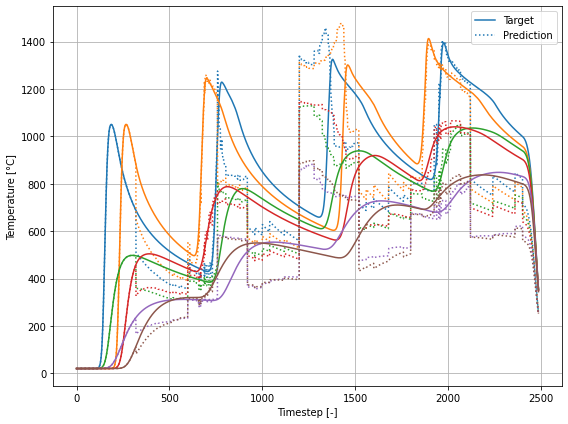

In [52]:
import os

os.makedirs('output', exist_ok=True)

fig, ax = plt.subplots()
for i in range(6):
    ax.plot(sample_test_targets[:, i], color='C{}'.format(i), label='Target')
    ax.plot(sample_test_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction')
    
ax.grid()
ax.set_xlabel(r'Timestep [-]')
ax.set_ylabel(r'Temperature [°C]')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
plt.tight_layout()
plt.savefig('output/dt_test_4features.pdf', transparent=True)

### Multilayer Perceptron

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_hidden, output_size):
        
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden = num_hidden
        self.output_size = output_size
        
        hidden = []
        for _ in range(self.num_hidden - 1):
            hidden.append(nn.Linear(self.hidden_size, self.hidden_size))
            hidden.append(nn.ReLU())
            
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            *hidden,
            nn.Linear(self.hidden_size, self.output_size)
        )
        
    def forward(self, x):
        return self.layers(x)

In [103]:
train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()
eval_inputs = torch.from_numpy(eval_inputs).float()
eval_targets = torch.from_numpy(eval_targets).float()
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets).float()

TypeError: expected np.ndarray (got Tensor)

In [113]:
# Hyperparameters
LR = 1e-3
BATCH_SIZE = 32
INPUT_SIZE = train_inputs.shape[1]
HIDDEN_SIZE = 32
NUM_HIDDEN = 2
OUTPUT_SIZE = train_targets.shape[1]
N_EPOCHS_CONVERGENCE = 5

In [126]:
mlp = MLP(
    INPUT_SIZE,
    HIDDEN_SIZE,
    NUM_HIDDEN,
    OUTPUT_SIZE
)

optimizer = optim.Adam(mlp.parameters(), lr=LR)

In [127]:
from copy import deepcopy

# Train model
best_loss, nb_epoch_no_improvement, best_weights = np.inf, 0, deepcopy(mlp.state_dict())
train_losses, eval_losses = [], []
epoch = 0
while nb_epoch_no_improvement <= N_EPOCHS_CONVERGENCE:
    
    # TRAINING PHASE
    train_loss = 0.0
    permutation = torch.randperm(train_inputs.shape[0])
    for b in range(0, train_inputs.shape[0], BATCH_SIZE):
        batch_indices = permutation[b:b+BATCH_SIZE]
        batch_inputs = train_inputs[batch_indices]
        batch_targets = train_targets[batch_indices]
        
        batch_preds = mlp(batch_inputs)
        loss = F.mse_loss(batch_preds, batch_targets)
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= int(train_inputs.shape[0] / BATCH_SIZE)
    train_losses.append(train_loss)
    
    # VALIDATION PHASE
    val_loss = 0.0
    with torch.no_grad():
        eval_preds = mlp(eval_inputs)
        eval_loss = F.mse_loss(eval_preds, eval_targets).item()
    eval_losses.append(eval_loss)
    
    # UPDATE STATISTICS
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_weights = deepcopy(mlp.state_dict())
        nb_epoch_no_improvement = 0
    else:
        nb_epoch_no_improvement += 1
    epoch += 1
        
    print('Epoch {:03d}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, eval_loss))

# Load best weights
mlp.load_state_dict(best_weights)

Epoch 001, train loss: 28318.8577, val loss: 13366.7734
Epoch 002, train loss: 11535.6951, val loss: 10521.5352
Epoch 003, train loss: 9490.2996, val loss: 8667.8096
Epoch 004, train loss: 7761.0147, val loss: 7332.5298
Epoch 005, train loss: 6574.8221, val loss: 6061.9688
Epoch 006, train loss: 5503.5043, val loss: 4854.6323
Epoch 007, train loss: 4595.0486, val loss: 4113.8843
Epoch 008, train loss: 3901.6121, val loss: 3722.7346
Epoch 009, train loss: 3317.4885, val loss: 3269.8547
Epoch 010, train loss: 2835.1152, val loss: 2560.1653
Epoch 011, train loss: 2455.7510, val loss: 2272.6079
Epoch 012, train loss: 2158.8038, val loss: 2039.3966
Epoch 013, train loss: 1918.0789, val loss: 1914.7341
Epoch 014, train loss: 1700.4476, val loss: 1690.5908
Epoch 015, train loss: 1529.7797, val loss: 1456.3080
Epoch 016, train loss: 1415.5635, val loss: 1456.4000
Epoch 017, train loss: 1312.7332, val loss: 1321.3804
Epoch 018, train loss: 1242.4419, val loss: 1340.3982
Epoch 019, train loss: 1

<All keys matched successfully>

### Evaluate the MLP

In [11]:
# Choose random evaluation sequence and plot its prediction
sample_eval_id = np.random.choice(eval_sequence_ids, size=(1,))
sample_eval_inputs, sample_eval_targets = load_data(sample_eval_id, recurrent=False)
sample_eval_inputs = torch.from_numpy(sample_eval_inputs).float()
sample_eval_targets = torch.from_numpy(sample_eval_targets).float()

with torch.no_grad():
    sample_eval_preds = mlp(sample_eval_inputs)

for i in range(6):
    plt.plot(sample_eval_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_eval_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.grid()
#     plt.legend()

NameError: name 'torch' is not defined

### Recurrent Neural Network

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    
    def __init__(self, input_size, cell, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        if cell == 'gru':
            self.rnn = nn.GRU(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            )
        elif cell == 'lstm':
            self.rnn = nn.LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            )
        else:
            raise NotImplementedError
            
        self.linear = nn.Linear(self.hidden_size, self.output_size)
            
    def forward(self, x, h0=None):
        x, hn = self.rnn(x, h0)
        x, lens = pad_packed_sequence(x)
        return self.linear(x), hn

In [56]:
# Load data and pad it
train_inputs, train_targets, train_in_seq_lens, train_tar_seq_lens = load_data(train_sequence_ids, recurrent=True)
eval_inputs, eval_targets, eval_in_seq_lens, eval_tar_seq_lens = load_data(eval_sequence_ids, recurrent=True)
test_inputs, test_targets, test_in_seq_lens, test_tar_seq_lens = load_data(test_sequence_ids, recurrent=True)

train_inputs = torch.from_numpy(train_inputs).float()
train_in_seq_lens = torch.LongTensor(train_in_seq_lens)
train_targets = torch.from_numpy(train_targets).float()
train_tar_seq_lens = torch.LongTensor(train_tar_seq_lens)
eval_inputs = torch.from_numpy(eval_inputs).float()
eval_in_seq_lens = torch.LongTensor(eval_in_seq_lens)
eval_targets = torch.from_numpy(eval_targets).float()
eval_tar_seq_lens = torch.LongTensor(eval_tar_seq_lens)
test_inputs = torch.from_numpy(test_inputs).float()
test_in_seq_lens = torch.LongTensor(test_in_seq_lens)
test_targets = torch.from_numpy(test_targets).float()
test_tar_seq_lens = torch.LongTensor(test_tar_seq_lens)

print(train_inputs.shape)
print(train_targets.shape)

torch.Size([2960, 84, 3])
torch.Size([2960, 84, 6])


In [57]:
# Hyperparameters
LR = 1e-3
BATCH_SIZE = 8
INPUT_SIZE = train_inputs.shape[2]
OUTPUT_SIZE = train_targets.shape[2]
HIDDEN_SIZE = 32
NUM_LAYERS = 2
N_EPOCHS_CONVERGENCE = 5

rnn = RNN(
    INPUT_SIZE,
    'gru',
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE
)

optimizer = optim.Adam(rnn.parameters(), lr=LR)

In [58]:
from copy import deepcopy

# Train model
best_loss, nb_epoch_no_improvement, best_weights = np.inf, 0, deepcopy(rnn.state_dict())
train_losses, eval_losses = [], []
epoch = 0
while nb_epoch_no_improvement <= N_EPOCHS_CONVERGENCE:
    
    # TRAINING PHASE
    train_loss = 0.0
    permutation = torch.randperm(train_inputs.shape[1])
    for b in range(0, train_inputs.shape[1], BATCH_SIZE):
        batch_indices = permutation[b:b+BATCH_SIZE]
        batch_lengths = train_in_seq_lens[batch_indices]
        batch_inputs = pack_padded_sequence(train_inputs[:, batch_indices, :], 
                                            lengths=batch_lengths,
                                            enforce_sorted=False
                                           )
        batch_targets = train_targets[:, batch_indices, :]
        batch_preds, batch_hn = rnn(batch_inputs)
        
        batch_targets = batch_targets[:batch_lengths.max(), :, :]
        
        print(batch_targets)
        print(batch_preds)
        
        loss = F.mse_loss(batch_preds, batch_targets)
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= int(train_inputs.shape[1] / BATCH_SIZE)
    train_losses.append(train_loss)
    
    # VALIDATION PHASE
    val_loss = 0.0
    packed_eval_inputs = pack_padded_sequence(eval_inputs,
                                              lengths=eval_in_seq_lens,
                                              enforce_sorted=False)
    with torch.no_grad():
        eval_preds, eval_hn = rnn(packed_eval_inputs)
        eval_loss = F.mse_loss(eval_preds, eval_targets).item()
    eval_losses.append(eval_loss)
    
    # UPDATE STATISTICS
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_weights = deepcopy(rnn.state_dict())
        nb_epoch_no_improvement = 0
    else:
        nb_epoch_no_improvement += 1
    epoch += 1
        
    print('Epoch {:03d}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, eval_loss))

# Load best weights
rnn.load_state_dict(best_weights)

tensor([[[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0

tensor([[[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0

tensor([[[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0

tensor([[[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0

tensor([[[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         ...,
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000]],

        [[ 20.0000,  20.0000,  20.0000,  20.0000,  20.0000,  20.0000],
         [ 20.0000,  20.0000,  20.0000,  20.0

KeyboardInterrupt: 